In [5]:
%autosave 0
%matplotlib notebook

from __future__ import division, print_function
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import pyedflib
fig_w, fig_h = (4.5, 3.5)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = False
config.gpu_options.visible_device_list = '0'
set_session(tf.Session(config=config))

Autosave disabled


## Configuration settings

In [2]:
import mod_edf

path_folder = '/share/datasets/sleep-edfx/'

edf_ids_excluded =  ['SC4061', 'ST7071', 'ST7092', 'ST7132', 'ST7141']

channels_ref = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

channels_ref_short = ['EEG1', 'EEG2', 'EOG1', 'EMG1']

metric_short = {'loss': 'loss', 'categorical_accuracy': 'acc'}

freq_target = 60

## Get dataset files

In [3]:
# get list of filenames
edf_files = [item for item in os.listdir(path_folder)
                  if (os.path.splitext(item)[1]).lower()=='.edf']

edf_first_night = [item for item in os.listdir(path_folder)
                  if (os.path.splitext(item)[1]).lower()=='.edf' and item[5]=='1' ]


edf_ids = set([item[:6] for item in edf_first_night
                        if item[:6]not in edf_ids_excluded])
psg_files, hyp_files = ([], [])

for edf_id in sorted(edf_ids):
    
    psg_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-PSG.edf'))][0]]

    hyp_files += [[os.path.join(path_folder, item) for item in edf_first_night
                     if (item[:6]==edf_id and item.endswith('-Hypnogram.edf'))][0]]


print(len(psg_files), len(hyp_files))

29 29


## Get files informations

Get informations about files durations, start time for each file

In [6]:
for psg_file, hyp_file in zip(psg_files, hyp_files):
        
    with pyedflib.EdfReader(os.path.join(path_folder, psg_file)) as psg, \
         pyedflib.EdfReader(os.path.join(path_folder, hyp_file)) as hyp:
        psg_start_datetime = psg.getStartdatetime()
        hyp_start_datetime = hyp.getStartdatetime()
        
        psg_file_duration = psg.getFileDuration()
        hyp_file_duration = sum(hyp.readAnnotations()[1])
        
        print("psg_start_datetime:"+str(psg_start_datetime))
        print("Duration_psg:"+str(psg_file_duration))

psg_start_datetime:1989-04-24 16:13:00
Duration_psg:79500
psg_start_datetime:1989-03-29 16:49:00
Duration_psg:84060
psg_start_datetime:1989-04-05 16:48:00
Duration_psg:84120
psg_start_datetime:1989-04-10 16:50:00
Duration_psg:84600
psg_start_datetime:1989-04-24 16:50:00
Duration_psg:77100
psg_start_datetime:1989-04-26 16:25:00
Duration_psg:81660
psg_start_datetime:1989-05-17 17:05:00
Duration_psg:84300
psg_start_datetime:1989-05-24 16:37:00
Duration_psg:83880
psg_start_datetime:1989-06-05 16:24:00
Duration_psg:81960
psg_start_datetime:1989-04-17 16:50:00
Duration_psg:81600
psg_start_datetime:1989-05-01 16:29:00
Duration_psg:79260
psg_start_datetime:1989-05-22 16:02:00
Duration_psg:83580
psg_start_datetime:1989-06-14 16:19:00
Duration_psg:84420
psg_start_datetime:1989-06-19 16:05:00
Duration_psg:82680
psg_start_datetime:1989-06-21 16:40:00
Duration_psg:78600
psg_start_datetime:1989-07-10 16:31:00
Duration_psg:78780
psg_start_datetime:1989-07-12 16:09:00
Duration_psg:82260
psg_start_date

## Check time alignment



The start time and duration of PSG is compared to that of hypnogram, and differences are reported.

In [7]:
print('Time delta between PSG and hypnogram\n')

for psg_file, hyp_file in zip(psg_files, hyp_files):
        
    with pyedflib.EdfReader(os.path.join(path_folder, psg_file)) as psg, \
         pyedflib.EdfReader(os.path.join(path_folder, hyp_file)) as hyp:
        
        psg_start_datetime = psg.getStartdatetime()
        hyp_start_datetime = hyp.getStartdatetime()
        psg_file_duration = psg.getFileDuration()
        hyp_start, hyp_duration, hyp_score = hyp.readAnnotations()
        
        if hyp_score[-1][-1]=='?':
            hyp_start = hyp_start[:-1]
            hyp_duration = hyp_duration[:-1]
            hyp_score = hyp_score[:-1]
            
        hyp_file_duration = sum(hyp_duration)

        time_delta = int(psg_file_duration-hyp_file_duration)
        
        assert (psg_start_datetime - hyp_start_datetime).total_seconds()==0, \
               'ERROR: different starting time.'
        
        if time_delta==0:
            print('ok\t', psg_file, hyp_file)
        else:
            print(time_delta, 's\t', psg_file, hyp_file, hyp_score[-1])


Time delta between PSG and hypnogram

ok	 /share/datasets/sleep-edfx/SC4001E0-PSG.edf /share/datasets/sleep-edfx/SC4001EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4011E0-PSG.edf /share/datasets/sleep-edfx/SC4011EH-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4021E0-PSG.edf /share/datasets/sleep-edfx/SC4021EH-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4031E0-PSG.edf /share/datasets/sleep-edfx/SC4031EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4041E0-PSG.edf /share/datasets/sleep-edfx/SC4041EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4051E0-PSG.edf /share/datasets/sleep-edfx/SC4051EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4071E0-PSG.edf /share/datasets/sleep-edfx/SC4071EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4081E0-PSG.edf /share/datasets/sleep-edfx/SC4081EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4091E0-PSG.edf /share/datasets/sleep-edfx/SC4091EC-Hypnogram.edf
ok	 /share/datasets/sleep-edfx/SC4101E0-PSG.edf /share/datasets/sleep-edfx/SC410

## Adjust time alignment between PSG and hypnogram

## Import dataset

Polysomnography (PSG) records are imported from edf files into the dictionary `dataset` with record filenames as keys.

Each record contains a dictionary with the following entries:

* `hypnogram` the hypnogram as an array of shape `(epochs, 1)`
* `signals` the PSG channels as a list of arrays of shape `(epochs, samples, 1)` , or an array of shape `(epochs, samples, channels)`
* `channels` the names of the PSG channels as a list
* `freqs` the frequencies of the PSG channels a list

In [8]:
# import dataset from list of filenames

dataset = mod_edf.load_sleep_edf(psg_files, hyp_files, channels_ref=channels_ref)

dataset_keys = sorted(dataset.keys())

opening 29 records 

 SC4001E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4011E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4021E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4031E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4041E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4051E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4071E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4081E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4091E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizontal', u'EMG submental'] [100.0, 100.0, 100.0, 1.0]
 SC4101E [u'EEG Fpz-Cz', u'EEG Pz-Oz', u'EOG horizon

In [12]:
dataset_records = sorted(dataset.keys())

record_ref = dataset_records[0]

dataset_record_ref = {item: dataset[record_ref][item] for item in dataset[record_ref]}

dataset_channels = dataset_record_ref['channels']

dataset_channels_short = [channels_ref_short[idx_channel]
                          for idx_channel, channel in enumerate(dataset_channels)]

## Data pre-processing

Several pre-processing steps are applied to the dataset prior to model training.

### Awake state event reduction

Sleep records may have important amounts of awake states in the beginning and end of the sessions. In order to reduce such frequency bias, these states are often removed up to 5 minutes before/after the first/last non awake sleep state.

In [13]:
awake_pre_post = 10

for record in dataset:
    
    hyp = dataset[record]['hypnogram']
    
    idx_start = max(0, np.where(hyp!=0)[0][0] - awake_pre_post)
    idx_end = min(np.where(hyp!=0)[0][-1] + awake_pre_post, hyp.shape[0])
    
    dataset[record]['hypnogram'] = dataset[record]['hypnogram'][idx_start:idx_end]
    
    for idx_channel in range(len(dataset[record]['channels'])):
        
        dataset[record]['signals'][idx_channel] =  dataset[record]['signals'][idx_channel][idx_start:idx_end]

### visualize hypnogram

<IPython.core.display.Javascript object>


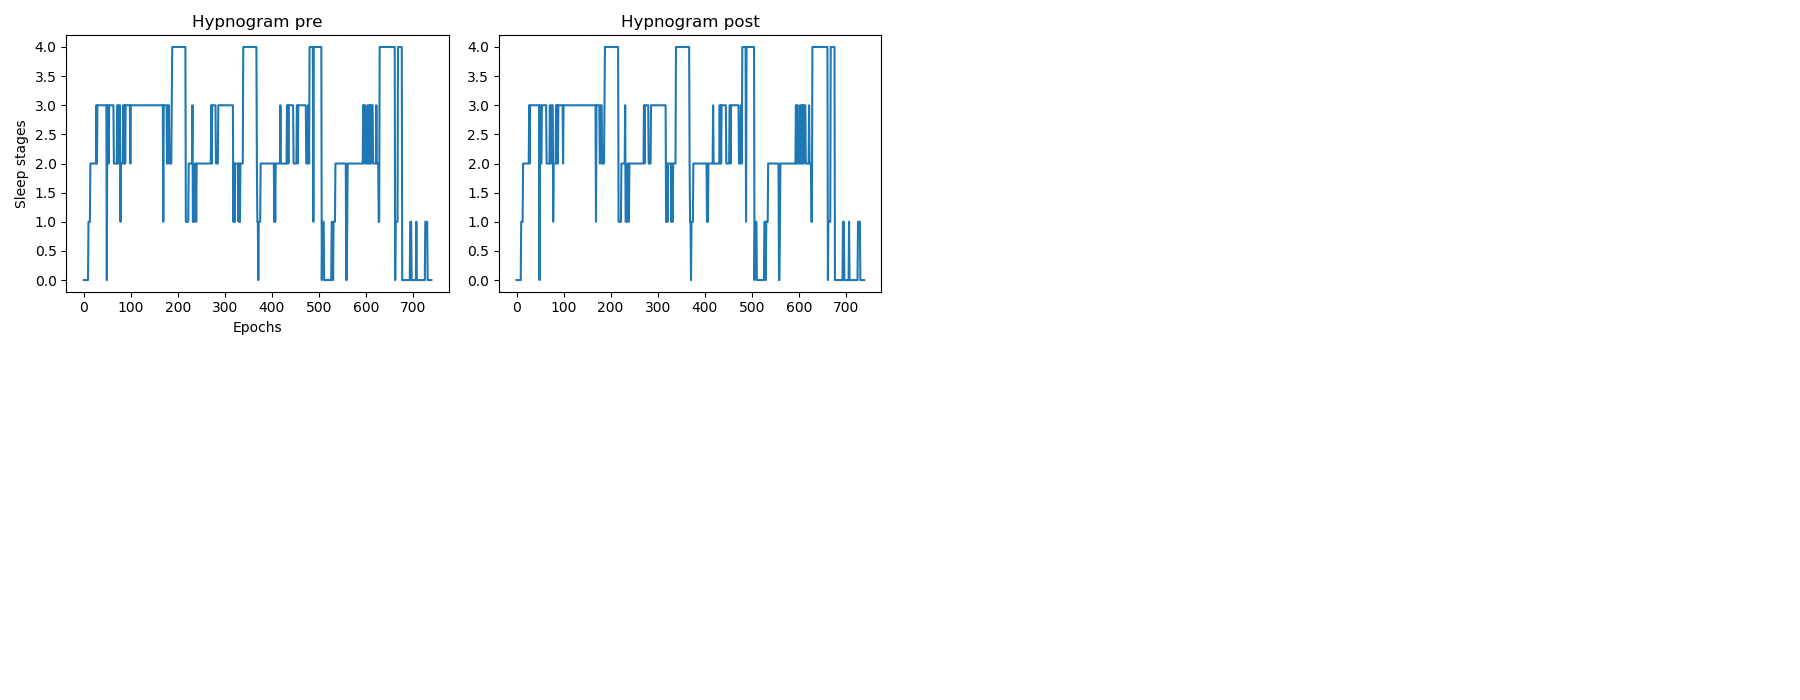

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(2*fig_w,fig_h))

plt.sca(axs[0])
hypno = dataset_record_ref['hypnogram']
plt.plot(dataset_record_ref['hypnogram'], label='pre')
plt.xlabel('Epochs')
plt.ylabel('Sleep stages')
plt.title('Hypnogram pre')

plt.sca(axs[1])
hypno = dataset[record_ref]['hypnogram']
plt.plot(hypno, label='pre')
plt.title('Hypnogram post')

plt.tight_layout()
fig.canvas.draw()

### Re-sample dataset to target frequency

The PSG records may contain channels sampled at different sampling rates and it may be necessary to set a global sampling rate and upsample or downsample channels accordingly. Downsampling PSG records has computational advantages by reducing the number of operations per mini-batch, and implements a natural low pass filter (at half the target frequency). Several studies indicate that low frequencies are the most relevant to sleep scoring.

In [15]:
from scipy import signal

def gcd(a, b):

    return gcd(b, a % b) if b else a


def updown(n1, n2):

    div = gcd(n1,n2)

    return (n2//div, n1//div)

In [16]:
# print unique frequencies in dataset

verbose = False

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(pre) unique frequencies in dataset', sorted(set(freqs)))

# resample dataset to target frequency
for record in dataset:
    
    for idx_channel, channel in enumerate(dataset[record]['channels']):
    
        freq = dataset[record]['freqs'][idx_channel]
        
        if freq!=freq_target:
            
            up, down = updown(freq, freq_target)
            
            data = dataset[record]['signals'][idx_channel]

            data_d = sp.signal.resample_poly(np.concatenate(data, axis=0), up, down)
            
            dataset[record]['signals'][idx_channel] = np.array(np.split(data_d , data.shape[0]))
            dataset[record]['freqs'][idx_channel] = freq_target
            
            if verbose:
                
                print(record, channel, freq, '->', freq_target)
        
# print unique frequencies in dataset

freqs = []
for record in dataset:
    freqs += dataset[record]['freqs']
    
print('(post) unique frequencies in dataset', sorted(set(freqs)))

(pre) unique frequencies in dataset [1.0, 100.0]


/share/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]


(post) unique frequencies in dataset [60]


### Stack PSG channels into numpy array

This is now possible since all channels have the same sampling frequency.

In [18]:
for record in dataset:
    
    if type(dataset[record]['signals'])==type(list()):
        dataset[record]['signals']= np.stack(dataset[record]['signals'], axis=2)

    print('sample record\t', record)
    print('PSG channels shape:\t', dataset[record]['signals'].shape)
    print('hypnogram shape:\t', dataset[record]['hypnogram'].shape)

sample record	 SC4101E
PSG channels shape:	 (1004, 1800, 4)
hypnogram shape:	 (1004, 1)
sample record	 ST7121J
PSG channels shape:	 (989, 1800, 4)
hypnogram shape:	 (989, 1)
sample record	 SC4001E
PSG channels shape:	 (740, 1800, 4)
hypnogram shape:	 (740, 1)
sample record	 SC4131E
PSG channels shape:	 (927, 1800, 4)
hypnogram shape:	 (927, 1)
sample record	 ST7061J
PSG channels shape:	 (991, 1800, 4)
hypnogram shape:	 (991, 1)
sample record	 ST7101J
PSG channels shape:	 (1008, 1800, 4)
hypnogram shape:	 (1008, 1)
sample record	 SC4121E
PSG channels shape:	 (951, 1800, 4)
hypnogram shape:	 (951, 1)
sample record	 ST7171J
PSG channels shape:	 (868, 1800, 4)
hypnogram shape:	 (868, 1)
sample record	 SC4081E
PSG channels shape:	 (1033, 1800, 4)
hypnogram shape:	 (1033, 1)
sample record	 SC4091E
PSG channels shape:	 (1042, 1800, 4)
hypnogram shape:	 (1042, 1)
sample record	 SC4011E
PSG channels shape:	 (1002, 1800, 4)
hypnogram shape:	 (1002, 1)
sample record	 SC4151E
PSG channels shape:	 

In [19]:
channel_masks = [[True, True, True, True], 
                [False, True, True, True],
                [True, False, True, True],
                 [True, True, False, True],
                [True, True, True, False]]

channel_masks_names = ['_'.join(np.array(channels_ref_short)[mask]) for mask in channel_masks]


### Perform combination between channels